# Recurrent spiking neural networks
This notebook provides an example in how to:
    * Set up a recurrent-spiking neural network
    * Generate data to give to it as input
    * Train the network so that it matches the data

Sources for this notebook include:
    * [The CURBD tool](https://github.com/rajanlab/CURBD)

# Creating the network

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy.random as npr
import math

## Neurons
Neurons are modeled by the time evolution of their membrane potential $V$:

$$\tau\frac{dV_{i}}{dt} = -V + g\sum\limits_{j}J_{ij}\phi(V_{j}) + I_{i}$$

This differential equation is solved using the Euler method, so the evolution of the voltage from one timestep to another is:

$$V_{i}(t + \Delta t) = V_{i}(t) + \frac{-V_{i}(t) + g\sum\limits_{j}J_{ij}\phi(V_{j}(t)) + I_{i}(t)}{\tau}\Delta t$$

In [1]:
n_neurons = 300
g = 1.5 #Neuron's conductance
tau_neuron = 0.1 #Neuron's time constant

def init_neurons(n_neurons):
    return npr.normal(
            -0.7, #Minimum value
            0.7, #Maximum value
            (n_neurons, 1) #(n_neurons, n_timesteps)
            )

init_neurons(n_neurons)

array([[-5.31908626e-01],
       [-1.56645609e+00],
       [-2.12856878e+00],
       [-4.04982792e-01],
       [-4.71867578e-01],
       [-8.13668196e-01],
       [-5.44839320e-01],
       [ 3.65721268e-02],
       [-3.60709079e-01],
       [ 1.12681185e-01],
       [-7.81820462e-01],
       [-8.49527865e-01],
       [-1.17972959e+00],
       [-1.39042396e+00],
       [ 3.08809901e-01],
       [-1.66734848e+00],
       [-1.38188622e-01],
       [-9.95852808e-01],
       [ 6.43953772e-01],
       [ 4.28665478e-01],
       [-8.55114520e-01],
       [-1.35172487e+00],
       [-1.39006913e+00],
       [-8.29865134e-01],
       [-1.46655050e+00],
       [-1.40065722e+00],
       [-3.56164070e-01],
       [-3.27625386e-01],
       [-9.05655508e-01],
       [ 3.06480731e-01],
       [-1.30549855e+00],
       [ 3.16669305e-02],
       [-1.69631264e-01],
       [-2.43227140e+00],
       [-9.57431377e-01],
       [-8.63319002e-01],
       [-1.29200702e+00],
       [-4.50772127e-01],
       [ 8.5

In [ ]:
def get_activity(V, phi):
    return phi(V)

def update_voltage(V, g, J, I, activity, tau, dt):
    return V + (-V + g * J.dot(activity) + I) * dt / tau

## Synapses
The synapses are represented as a matrix $J$ of size $n \times n$. where $n$ is the number of neurons.
The value of $J_{ij}$ represents the strength of the connection between neuron $i$ and neuron $j$, such that:
* $J_{ij} > 0$ means that neuron $i$ excites neuron $j$.
* $J_{ij} < 0$ means that neuron $i$ inhibits neuron $j$.
* $J_{ij} = 0$ means that there is no connection between neuron $i$ and neuron $j$.

The matrix is initialized with random values distributed as a normal distribution and then normalized according to the number of neurons $n$:

$$J_{ij} \sim \frac{N(0, 1)}{\sqrt{n}}$$

In [2]:
def init_synapses(n_neurons):
    return npr.randn(n_neurons, n_neurons) / math.sqrt(n_neurons)
init_synapses(n_neurons)

array([[ 0.01284209, -0.06295191, -0.11562444, ...,  0.06903869,
         0.0009759 ,  0.04907899],
       [ 0.02993069, -0.04743361,  0.01484246, ...,  0.12329994,
         0.06531392,  0.01247343],
       [ 0.0495402 , -0.04000321, -0.0097075 , ...,  0.00157472,
         0.09746359,  0.00119553],
       ...,
       [ 0.06175827,  0.09799117,  0.03853161, ...,  0.08970147,
         0.0137029 ,  0.12908389],
       [ 0.09003697,  0.10922602, -0.00275863, ...,  0.00363049,
         0.10851053, -0.07540217],
       [ 0.03056233,  0.04199885, -0.07609534, ..., -0.09088349,
         0.01595101, -0.02663508]])

Installed gtk3 event loop hook.


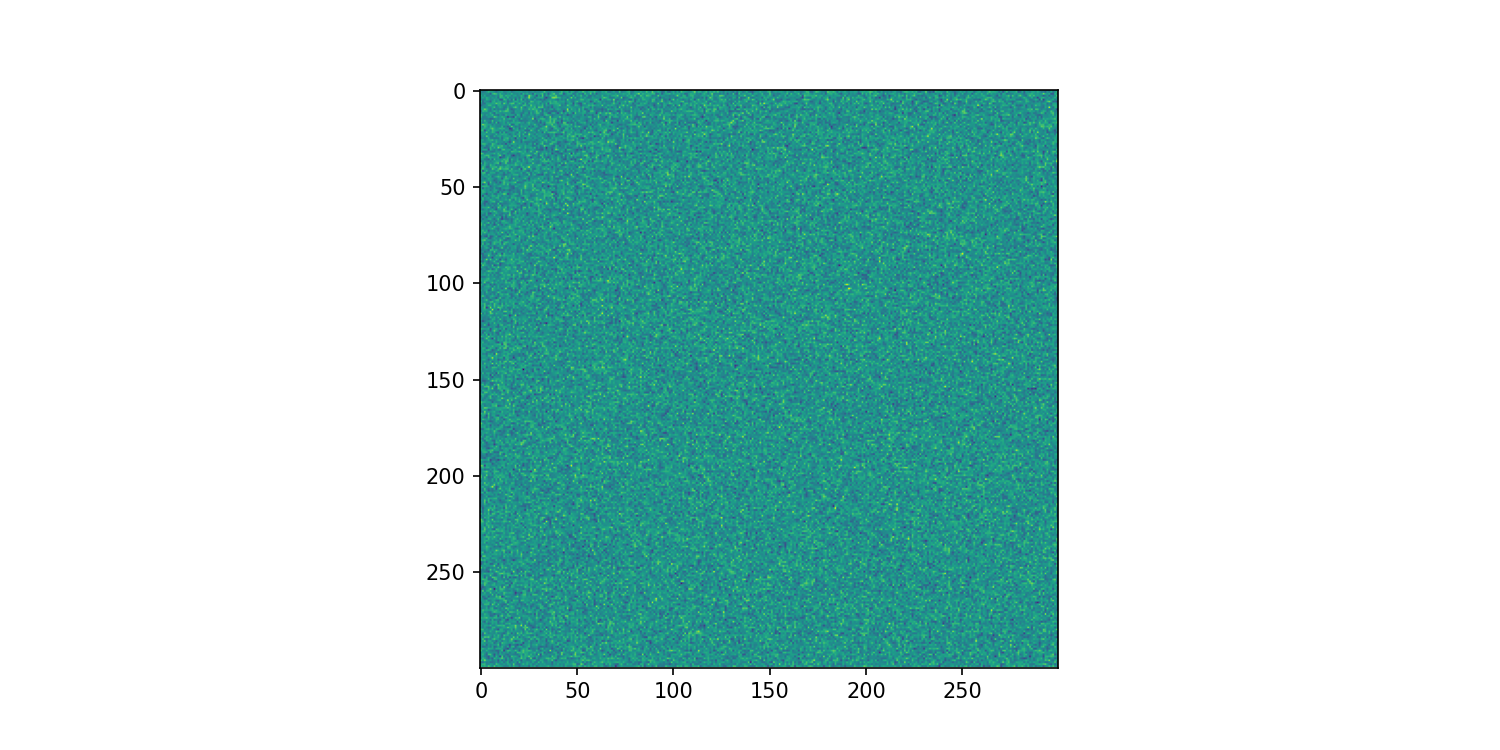

In [3]:
figure, subplot = plt.subplots(1, figsize=(10, 5))
subplot.imshow(init_synapses(n_neurons))

## Input
The input I is computed as:

$$I_{i}(t) = \eta_{i}(t) + (I_{i}(t - \Delta t) - \eta_{i}(t))e^{-\frac{\Delta t}{\tau}}$$

Where $\eta_{i}(t)$ is a white noise process with a time constant $\tau$.

This is done to ensure that the input of different neurons is not correlated.

In [ ]:
tau_input = 0.1 #The time constant of the input
dt = 0.01 / 5 #The timestep of the input
scale_input = 0.01 #The scale of the input

def compute_input(n_neurons, tau_input, scale_input, dt, sim_time):
    n_timesteps = int(np.ceil(sim_time / dt)) #The number of timesteps
    eta = npr.randn(n_neurons, n_timesteps) * math.sqrt(tau_input / dt) #The noise process
    I = np.ones((n_neurons, n_timesteps)) #Initializing the input

    for i in range(1, n_timesteps): #Computing the input
        I[:, i] = eta[:, i] + (I[:, i - 1] - eta[:, i]) * np.exp(-dt / tau_input)

    return I * scale_input

I = compute_input(300, tau_input, scale_input, dt, 12)

Text(0, 0.5, 'Input current')


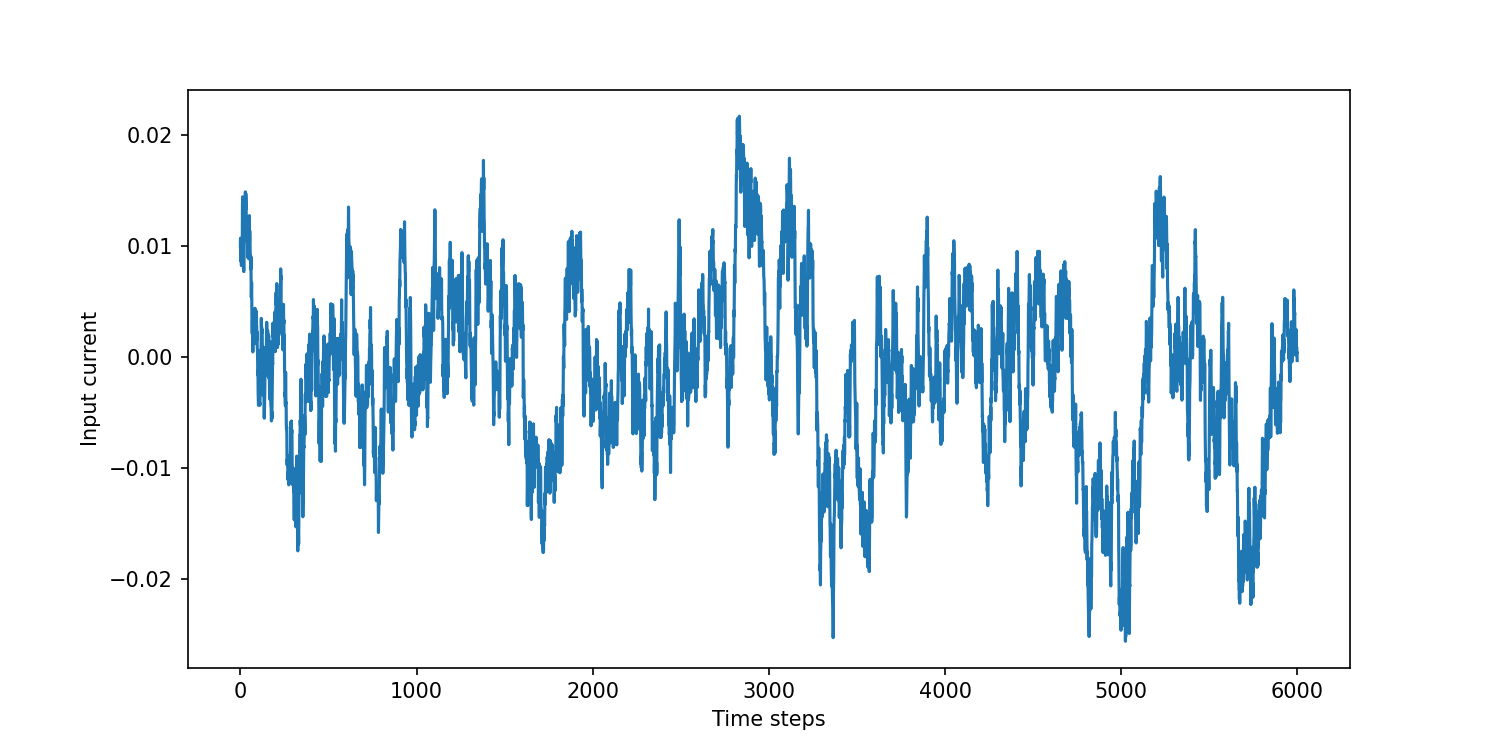

In [4]:
figure, subplot = plt.subplots(1, figsize=(10, 5))

subplot.plot(I[0, :])
subplot.set_xlabel("Time steps")
subplot.set_ylabel("Input current")

Text(0, 0.5, 'Neurons')


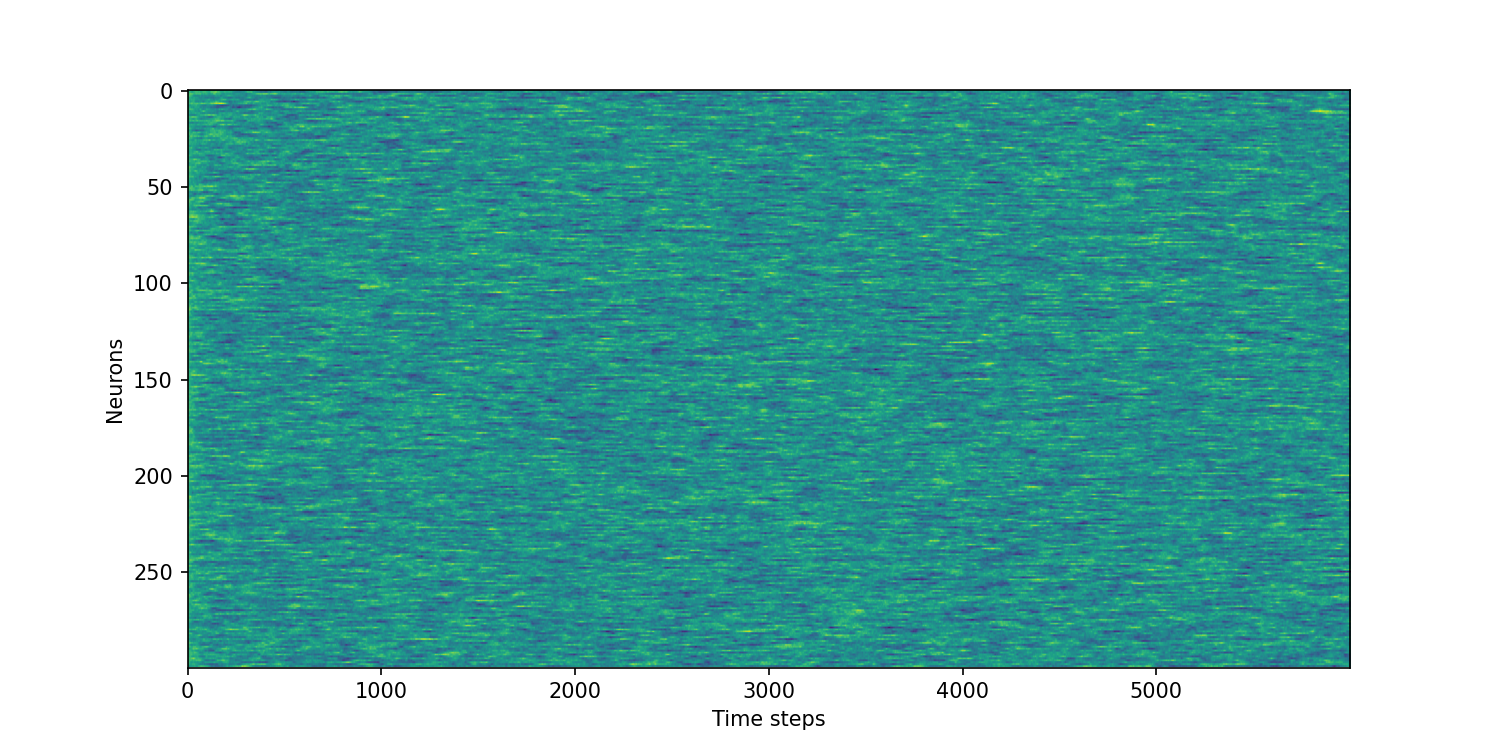

In [5]:
figure, subplot = plt.subplots(1, figsize=(10, 5))

subplot.imshow(I, aspect = 'auto')
subplot.set_xlabel("Time steps")
subplot.set_ylabel("Neurons")

## Activation function
The activation function is any non-linear function like:
* The sigmoid.
* The hyperbolic tangent.
* The rectified linear unit (ReLU)

In this case the hyperbolic tangent is used:

$$\phi(x) = \tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$$

With its derivative:

$$\phi'(x) = 1 - \tanh^{2}(x) = 1 - \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}^{2}$$

In [ ]:
phi = np.tanh

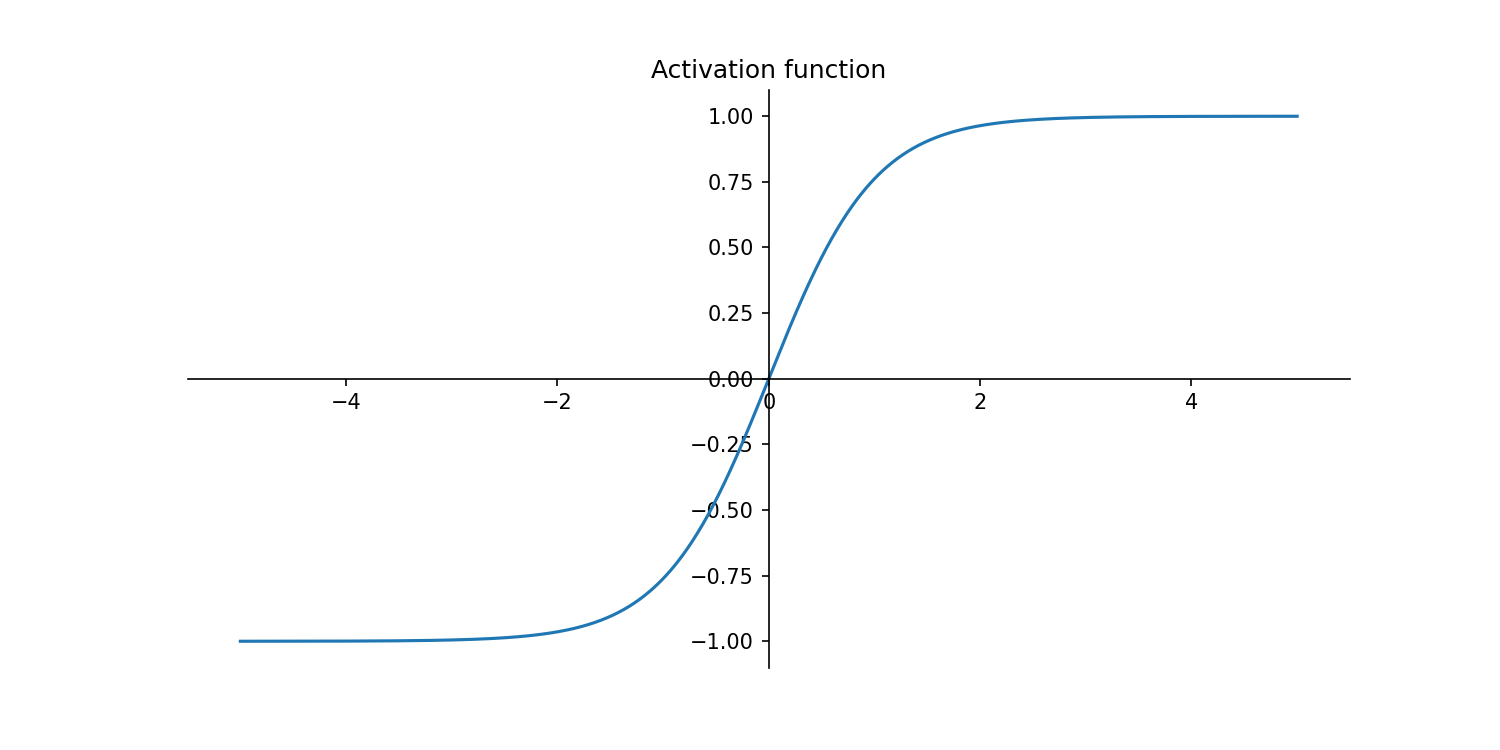

In [6]:
x = np.linspace(-5, 5, 1000)
y = phi(x)
figure, subplot = plt.subplots(1, figsize=(10, 5))
subplot.spines['left'].set_position('center')
subplot.spines['bottom'].set_position('center')
subplot.spines['right'].set_color('none')
subplot.spines['top'].set_color('none')
subplot.xaxis.set_ticks_position('bottom')
subplot.yaxis.set_ticks_position('left')
subplot.set_title("Activation function")
subplot.plot(x, y)

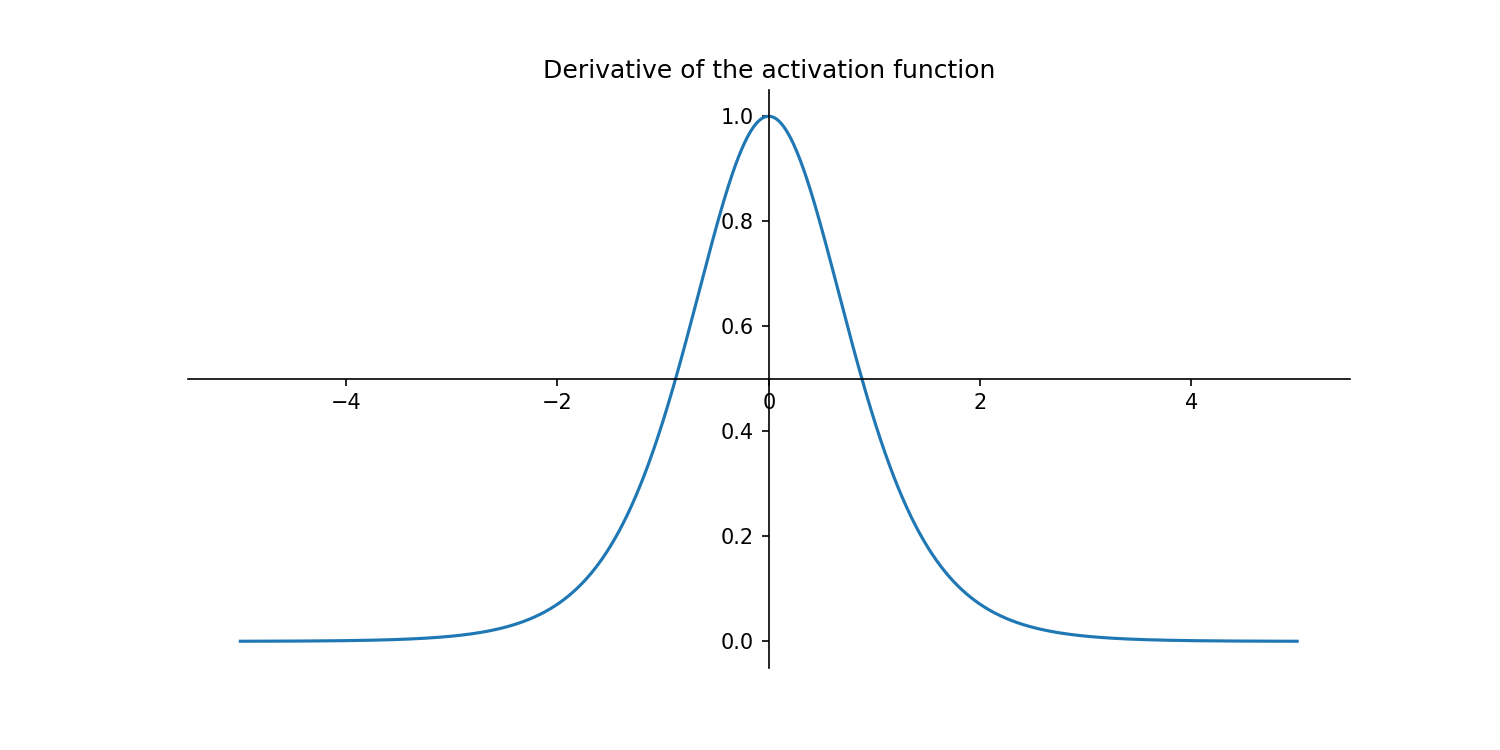

In [7]:
figure, subplot = plt.subplots(1, figsize=(10, 5))
subplot.spines['left'].set_position('center')
subplot.spines['bottom'].set_position('center')
subplot.spines['right'].set_color('none')
subplot.spines['top'].set_color('none')
subplot.xaxis.set_ticks_position('bottom')
subplot.yaxis.set_ticks_position('left')
subplot.set_title("Derivative of the activation function")
subplot.plot(x, 1 - y**2)

# Training
Training consists of updating the strength of the synapses connections $J_{ij}$ so that the activity of the neurons is as close as possible to the one found in the experimental data.
This is done by computing the error between the experimental data and the output of the network and then updating the synapses connections according to the error:

$$J_{ij}(t) = J_{ij}(t-1) + \Delta J_{ij}(t)$$

$$\Delta J_{ij}(t) = c\cdot e_{i}(t)\sum\limits_{k=1}^N P_{jk}(t)\phi_{k}(t)$$

## Error function
The error function is the difference between the experimental data and the output of the network:

$$e_{i}(t) = z_{i}(t) - a_{i}(t)$$

In [ ]:
def get_error(simulated, experimental):
    return simulated - experimental

## Inverse cross-correlation matrix
$P$ is the probability that neuron $j$ will fire in the next timestep, so the inverse cross-correlation matrix of the firing rates of units in the network.

$$P_{ij} = \langle\phi_{i}\phi_{j}\rangle^{-1}$$

This is costly to compute at every timestep, so it is computed iteratively as:

$$P(t) = P(t-1) - c\cdot ||(P(t-1)\cdot\phi(t))|| = P(t-1) - c\cdot((P(t-1)\cdot\phi(t))(P(t-1)\cdot\phi(t))^T)$$

In [ ]:
learning_rate = 1.0 #Works best when set to be 1 to 10 times the overall amplitude of the external inputs

def init_P(n_neurons, learning_rate):
    return learning_rate * np.eye(n_neurons)

In [ ]:
def get_activity_P(P, activity):
    return P.dot(activity)

In [ ]:
def update_P(P, activity_P, c):
    return P - c * activity_P.dot(activity_P.T)

## Scaling term
The scaling term $c$ scales the update of the synapses connections.
It is computed as:

$c = \frac{1}{1+\phi^{T}(t)\cdot(P(t-1)\cdot\phi(t))}$

In [ ]:
def get_c(activity_P, activity):
    aPa = activity.T.dot(activity_P).item() # The result is a singleton, item extracts the number
    return 1 / (1 + aPa)

## Update of the synapses Matrix
Recall:

$$\Delta J_{ij}(t) = c\cdot e_{i}(t)\sum\limits_{k=1}^N P_{jk}(t)\phi_{k}(t)$$

In [ ]:
def update_J(J, activity_P, error, c, target_neurons):
    return J[:, target_neurons] - c * np.outer(error.flatten(), activity_P.flatten())

## Training function
Now that all the function have been defined, they can be collected in a single function that performs the training of the network.

In [ ]:
def train(simulated, experimental, J, P, target_neurons):
    error = get_error(simulated, experimental)
    activity_P = get_activity_P(P, simulated[target_neurons,:])
    c = get_c(activity_P, simulated[target_neurons,:])
    P = update_P(P, activity_P, c)
    J[:, target_neurons.flatten()] = update_J(J, activity_P, error, c, target_neurons)
    return J, P, np.mean(error ** 2)

In [8]:
neurons = np.zeros((300, 1)) + npr.normal(-0.7, 0.7, (300, 1))
print(neurons[0,0])

for i in range (100):
    neurons = update_voltage(neurons, 1.2, np.ones((neurons.shape[0], neurons.shape[0])) * 0.0001, np.zeros(neurons.shape), np.tanh, 0.1, 0.1)
    print(neurons[0,0])

-0.8322332964445396
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Cell In[30], line 5
      2 print(neurons[0,0])
      4 for i in range (100):
----> 5     neurons = update_voltage(neurons, 1.2, np.ones((neurons.shape[0], neurons.shape[0])) * 0.0001, np.zeros(neurons.shape), np.tanh, 0.1, 0.1)
      6     print(neurons[0,0])

Cell In[5], line 5, in update_voltage(V, g, J, I, activity, tau, dt)
      4 def update_voltage(V, g, J, I, activity, tau, dt):
----> 5     return V + (-V + g * J.dot(activity) + I) * dt / tau

TypeError: unsupported operand type(s) for *: 'float' and 'numpy.ufunc'


# The experimental data
To demonstrate the capabilities of the network the experimental data will be generated in silico as well.
The data will be generated according to a three region ground truth model.
Each of the tree regions will contain $100$ neurons and will be driven by a different type of input:

* The first region (A) will be driven by only by the recurrent inuts from the other two regions.
* The second region (B) will be driven by a network generating a Gaussian "bump" propagating agross the network:
* The final region (C) will be driven by a network generating a fixed point that is shifted then to another during the generation.
The fixed points are generated by sampling $SQ_{i}(t)$ at two differend time points and holding them at the sampled value for the duration of the fixed point.

External inputs are connected to half of the units in their respective regions with a fixed negative weight (inhibitory) for region B and positive (excitatory) for region C.

## Generating the external inputs

### The Gaussian bump
$$ SQ_{i}(t) = e^{-\frac{1}{2\sigma^2}\left(\frac{1-\sigma-Nt}{T}\right)^2}$$
Where $\sigma$ is the width of the bump across the population, $N$ the population size and $t$ the total simulation time.

In [ ]:
def compute_x_bump(sim_time, dt, n_neurons, width, cutoff_traslation):
    """Selects which neurons have a higher firing rate.
    They will be sampled from a Gaussian distrubtion
    """
    n_samples = int(math.ceil(sim_time / dt))
    t_data = np.arange(0, sim_time, dt)
    x_bump = np.zeros((n_neurons, n_samples))
    n_width = width * n_neurons #from percentage to number
    norm = 2*n_width **2
    cutoff = math.ceil(n_samples / 2) + cutoff_traslation

    for i in range(n_neurons):
        x_bump[i, :] = np.exp(- ((i - n_width - n_neurons * t_data / (t_data[-1] / 2)) **2 / norm))
        x_bump[i, cutoff:] = x_bump[i, cutoff]

    return x_bump

### Sequence driving network
The sequence driving network is a network that generates a fixed point that is shifted during the simulation in a sequenctial manner across neurons.

In [ ]:
def sequence_driving_network(x_bump, dt , lead_time):
    hbump = np.log((x_bump + 0.01)/(1-x_bump+0.01))
    hbump -= np.min(hbump)
    hbump = hbump / np.max(hbump)
    newmat = np.tile(hbump[:, 1, np.newaxis], (1, math.ceil(lead_time / dt)))
    hbump = np.concatenate((newmat, hbump), axis=1)
    return hbump

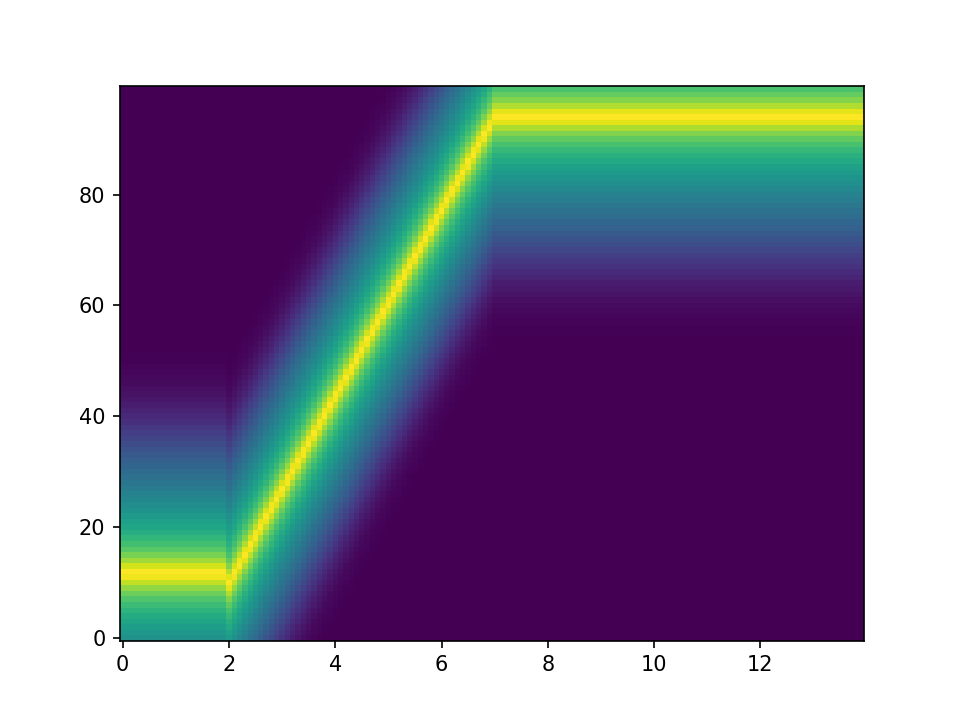

In [9]:
x_bump = compute_x_bump(12, 0.1, 100, 0.1, -10)
test = sequence_driving_network(x_bump, 0.1, 2)
figure, subplot = plt.subplots(1)
plt.pcolormesh(np.arange(0, 14, 0.1), np.arange(0, 100), test)

### Fixed point driving network
The fixed point driving network gnerates a fixed point that it is kept fixed until a certain point during the simulation, where it is translated to another neuron.

In [ ]:
def fixed_point_driver(xbump, sim_time, lead_time, dt, n_neurons, cutoff_traslation, before_shift, after_shift):
    """Generates a fixed point that is shifted during the simulation,
    cutoff_translation: where the shift happen
    before_shift where to pick the current from x_bump before the shift
    after_shift where to pick the current from x_bump after the shift
    """
    n_samples = int(math.ceil((sim_time - lead_time) / dt))
    print(n_samples)
    x_fp = np.zeros(xbump.shape)
    cutoff = math.ceil(n_samples / 2) + cutoff_traslation
    for i in range(n_neurons):
        front = xbump[i, before_shift] * np.ones((1, cutoff))
        back = xbump[i, after_shift] * np.ones((1, n_samples - cutoff))
        x_fp[i, :] = np.concatenate((front, back), axis = 1)
    h_fp = np.log((x_fp + 0.01)/(1-x_fp+0.01))
    h_fp -= np.min(h_fp)
    h_fp = h_fp / np.max(h_fp)
    newmat = np.tile(h_fp[:, 1, np.newaxis], (1, math.ceil(lead_time/dt)))
    h_fp = np.concatenate((newmat, h_fp), axis=1)
    return h_fp

In [10]:
test = fixed_point_driver(x_bump, 14, 2, 0.1, 100, -10, 10, 300)
figure, subplot = plt.subplots(1)
plt.pcolormesh(np.arange(0, 14, 0.1), np.arange(0, 100), test/np.max(test))

120
---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
Cell In[125], line 1
----> 1 test = fixed_point_driver(x_bump, 14, 2, 0.1, 100, -10, 10, 300)
      2 figure, subplot = plt.subplots(1)
      3 plt.pcolormesh(np.arange(0, 14, 0.1), np.arange(0, 100), test/np.max(test))

Cell In[124], line 13, in fixed_point_driver(xbump, sim_time, lead_time, dt, n_neurons, cutoff_traslation, before_shift, after_shift)
     11 for i in range(n_neurons):
     12     front = xbump[i, before_shift] * np.ones((1, cutoff))
---> 13     back = xbump[i, after_shift] * np.ones((1, n_samples - cutoff))
     14     x_fp[i, :] = np.concatenate((front, back), axis = 1)
     15 h_fp = np.log((x_fp + 0.01)/(1-x_fp+0.01))

IndexError: index 300 is out of bounds for axis 1 with size 120


## Connectivity

### Intra-region connectivity
Each of the three regions will have random inter-connections.
The strength of the connection is sampled by a normalized normal distribution:

$$J_{ij} \sim \mathcal{N}(0, \frac{1}{\sqrt{N_{in}}})$$

And then scaled by a chaos factor $g$:

$$J_{ij} = g\cdot J_{ij}$$

$g$ has to be sufficiently large so to facilitate chaotic dynamics in the network.

In [ ]:
def intra_region_connectivity(n_neurons, g):
    J = npr.randn(n_neurons, n_neurons)
    J = (g / np.sqrt(n_neurons)) * J
    return J

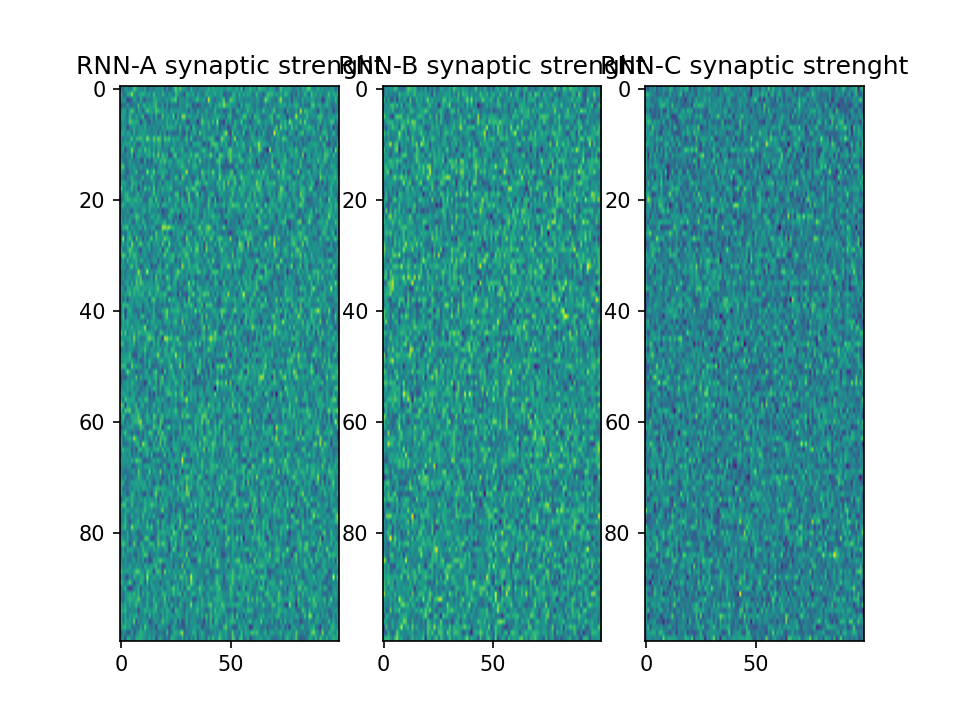

Text(0.5, 1.0, 'RNN-C synaptic strenght')

In [11]:
J_a = intra_region_connectivity(100, 1.8)
J_b = intra_region_connectivity(100, 1.5)
J_c = intra_region_connectivity(100, 1.5)

figure, subplot = plt.subplots(1, 3)
subplot[0].imshow(J_a, aspect = 'auto')
subplot[0].set_title("RNN-A synaptic strenght")
subplot[1].imshow(J_b, aspect = 'auto')
subplot[1].set_title("RNN-B synaptic strenght")
subplot[2].imshow(J_c, aspect = 'auto')
subplot[2].set_title("RNN-C synaptic strenght")

### Inter-region connectivity
The number of connection is controlled by the `frac_inter_reg`, which controls the percentage of connected neurons

In [ ]:
def source_region_neurons_connected(n_neurons, connected_fraction):
    """Returns the array source_neurons of the neurons
    in the source population, where source_neurons[i] = 1 if
    neuron i is connected to the population and 0 otherwise
    """
    n_connected = int(n_neurons * connected_fraction)
    source_neurons = np.zeros((n_neurons, 1))
    random_connected_neurons = npr.permutation(n_neurons)
    source_neurons[random_connected_neurons[0:n_connected]] = 1
    return source_neurons

In [12]:
frac_inter_reg = 0.05
connection_A_to_B = source_region_neurons_connected(100, frac_inter_reg)
connection_A_to_C = source_region_neurons_connected(100, frac_inter_reg)
connection_B_to_A = source_region_neurons_connected(100, frac_inter_reg)
connection_B_to_C = source_region_neurons_connected(100, frac_inter_reg)
connection_C_to_B = source_region_neurons_connected(100, frac_inter_reg)
connection_C_to_A = source_region_neurons_connected(100, frac_inter_reg)

frac_external_reg = 0.5

connection_sequence_to_B = source_region_neurons_connected(100, frac_external_reg)
connection_fixed_to_C = source_region_neurons_connected(100, frac_external_reg)

print("The number of connection between A and B is: ", np.sum(connection_A_to_B))
print("The number of connection between the sequence driver and B is: ", np.sum(connection_sequence_to_B))

The number of connection between A and B is:  5.0
The number of connection between the sequence driver and B is:  50.0


## Initial state
The initial state is a `n_neurons` vector of values sampled from a normal distribution.

In [ ]:
def get_initial_state(n_neurons):
    return 2 * npr.rand(n_neurons, 1) - 1

## Generating the data
To generate the data a number of parameters is necessary, so they are all collected in a dictionary.

In [ ]:
data_params = {
        'sim_time' : 12,
        'lead_time' : 2,
        'dt' : 0.01,
        'bump_width' : 0.2,
        'n_neurons_A' : 100,
        'n_neurons_B' : 100,
        'n_neurons_C' : 100,
        'g_A' : 1.8,
        'g_B' : 1.5,
        'g_C' : 1.5,
        'frac_inter_reg' : 0.05,
        'frac_ext_reg' : 0.5,
        'activation_function' : np.tanh,
        'tau' : 0.1,
        'amplitude_inter_region' : 0.02,
        'amplitude_sequential' : 1,
        'amplitude_fixed' : -1,
        'cutoff_traslation' : 100,
        'before_shift' : 10,
        'after_shift' : 300,
        }

n_datapoints = int(data_params['sim_time'] / data_params['dt'])
data = {}
connections = {}

### Setting up all the necessary variables

In [13]:
x_bump = compute_x_bump(
        data_params['sim_time'] - data_params['lead_time'],
        data_params['dt'],
        data_params['n_neurons_B'],
        data_params['bump_width'],
        -data_params['cutoff_traslation'],
        )

data = {
        'A' : np.empty((data_params['n_neurons_A'], n_datapoints)),
        'B' : np.empty((data_params['n_neurons_B'], n_datapoints)),
        'C' : np.empty((data_params['n_neurons_C'], n_datapoints)),
        'sequential' : sequence_driving_network(
            x_bump,
            data_params['dt'],
            data_params['lead_time']
            ),
        'fixed' : fixed_point_driver(
            x_bump,
            data_params['sim_time'],
            data_params['lead_time'],
            data_params['dt'],
            data_params['n_neurons_C'],
            data_params['cutoff_traslation'],
            data_params['befsubplots[2]ore_shift'],
            data_params['after_shift'],
            ),
        }

data['A'][:] = np.NaN
data['B'][:] = np.NaN
data['C'][:] = np.NaN

states = {
        'A' : get_initial_state(data_params['n_neurons_A']),
        'B' : get_initial_state(data_params['n_neurons_B']),
        'C' : get_initial_state(data_params['n_neurons_C']),
        }
connections['A'] = {
        'A' : {
            'J' : intra_region_connectivity(
                data_params['n_neurons_A'],
                data_params['g_A']
                ),
            },
        'B' : {
            'J' : source_region_neurons_connected(
                data_params['n_neurons_A'],
                data_params['frac_inter_reg']
                ),
            'w' : data_params['amplitude_inter_region'],
            },
        'C' : {
            'J' : source_region_neurons_connected(
                data_params['n_neurons_A'],
                data_params['frac_inter_reg']
                ),
            'w' : data_params['amplitude_inter_region'],
            },
        }
connections['B'] = {
        'A' : {
            'J' : source_region_neurons_connected(
                data_params['n_neurons_B'],
                data_params['frac_inter_reg']
                ),
            'w' : data_params['amplitude_inter_region'],
            },
        'B' : {
            'J' : intra_region_connectivity(
                data_params['n_neurons_B'],
                data_params['g_B']
                ),
            },
        'C' : {
            'region' : 'C',
            'J' : source_region_neurons_connected(
                data_params['n_neurons_B'],
                data_params['frac_inter_reg']
                ),
            'w' : data_params['amplitude_inter_region'],
            },
        'sequential' : {
            'J' : source_region_neurons_connected(
                data_params['n_neurons_B'],
                data_params['frac_ext_reg']
                ),
            'w' : data_params['amplitude_sequential'],
            },
        }
connections['C'] = {
        'A' : {
            'J' : source_region_neurons_connected(
                data_params['n_neurons_C'],
                data_params['frac_inter_reg']
                ),
            'w' : data_params['amplitude_inter_region'],
            },
        'B' : {
            'J' : source_region_neurons_connected(
                data_params['n_neurons_C'],
                data_params['frac_inter_reg']
                ),
            'w' : data_params['amplitude_inter_region'],
            },
        'C' : {
            'J' : intra_region_connectivity(
                data_params['n_neurons_C'],
                data_params['g_C']
                ),
        },
        'fixed' : {
            'J' : source_region_neurons_connected(
                data_params['n_neurons_C'],
                data_params['frac_ext_reg']
                ),
            'w' : data_params['amplitude_fixed'],
            },
        }

1000


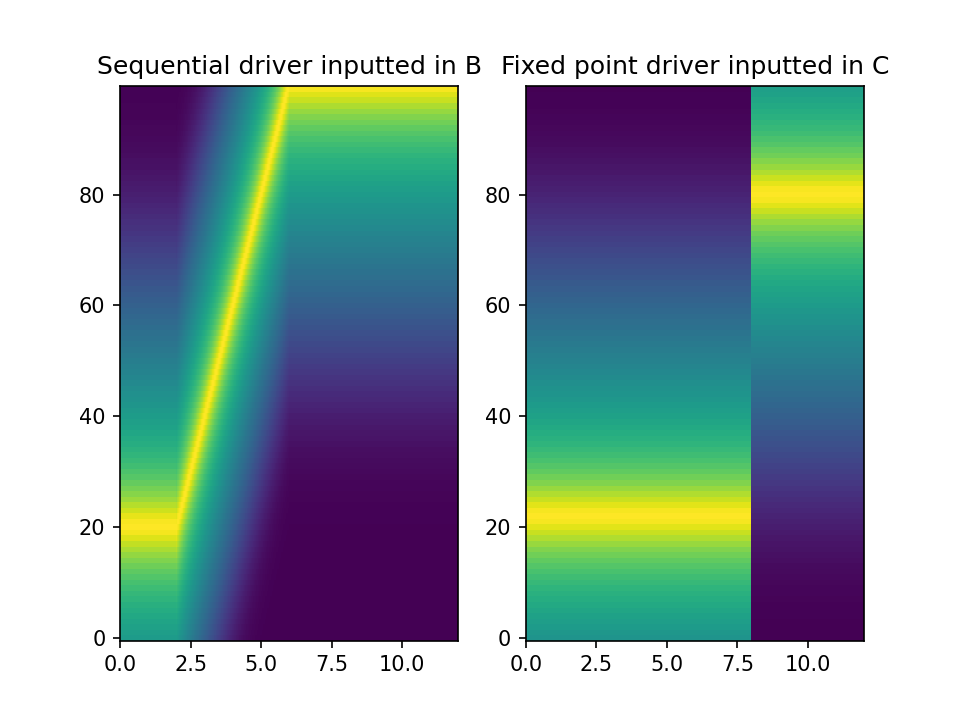

Text(0.5, 1.0, 'Fixed point driver inputted in C')

In [14]:
figure, subplots = plt.subplots(1, 2)
subplots[0].pcolormesh(
        np.arange(0, data_params['sim_time'], data_params['dt']),
        np.arange(0, data_params['n_neurons_B']),
        data['sequential']/np.max(data['sequential']))
subplots[0].set_title("Sequential driver inputted in B")

subplots[1].pcolormesh(
        np.arange(0, data_params['sim_time'], data_params['dt']),
        np.arange(0, data_params['n_neurons_C']),
        data['fixed']/np.max(data['fixed']))
subplots[1].set_title("Fixed point driver inputted in C")

### Some helpful functions

In [ ]:
def update_states(data, states, connections, dt, tau, t):
    for target in states:
        JR = connections[target][target]['J'].dot(data[target][:, t, np.newaxis])
        for source in connections[target]:
            if source != target:
                print(source, target)
                JR += connections[target][source]['w'] *\
                        connections[target][source]['J'] *\
                        data[source][:, t, np.newaxis]
        states[target] += dt * (-states[target] + JR) / tau
    return states

def save_states(data, states, phi, t):
    for region in states:
        data[region][:, t, np.newaxis] = phi(states[region])
    return data

In [15]:
for t in range(n_datapoints):
    data = save_states(
            data,
            states,
            data_params['activation_function'],
            t
            )
    states = update_states(
            data,
            states,
            connections,
            data_params['dt'],
            data_params['tau'],
            t
            )

B A
C A
A B
C B
sequential B
A C
B C
fixed C
B A
C A
A B
C B
sequential B
A C
B C
fixed C
B A
C A
A B
C B
sequential B
A C
B C
fixed C
B A
C A
A B
C B
sequential B
A C
B C
fixed C
B A
C A
A B
C B
sequential B
A C
B C
fixed C
B A
C A
A B
C B
sequential B
A C
B C
fixed C
B A
C A
A B
C B
sequential B
A C
B C
fixed C
B A
C A
A B
C B
sequential B
A C
B C
fixed C
B A
C A
A B
C B
sequential B
A C
B C
fixed C
B A
C A
A B
C B
sequential B
A C
B C
fixed C
B A
C A
A B
C B
sequential B
A C
B C
fixed C
B A
C A
A B
C B
sequential B
A C
B C
fixed C
B A
C A
A B
C B
sequential B
A C
B C
fixed C
B A
C A
A B
C B
sequential B
A C
B C
fixed C
B A
C A
A B
C B
sequential B
A C
B C
fixed C
B A
C A
A B
C B
sequential B
A C
B C
fixed C
B A
C A
A B
C B
sequential B
A C
B C
fixed C
B A
C A
A B
C B
sequential B
A C
B C
fixed C
B A
C A
A B
C B
sequential B
A C
B C
fixed C
B A
C A
A B
C B
sequential B
A C
B C
fixed C
B A
C A
A B
C B
sequential B
A C
B C
fixed C
B A
C A
A B
C B
sequential B
A C
B C
fixed C
B A
C A
A 

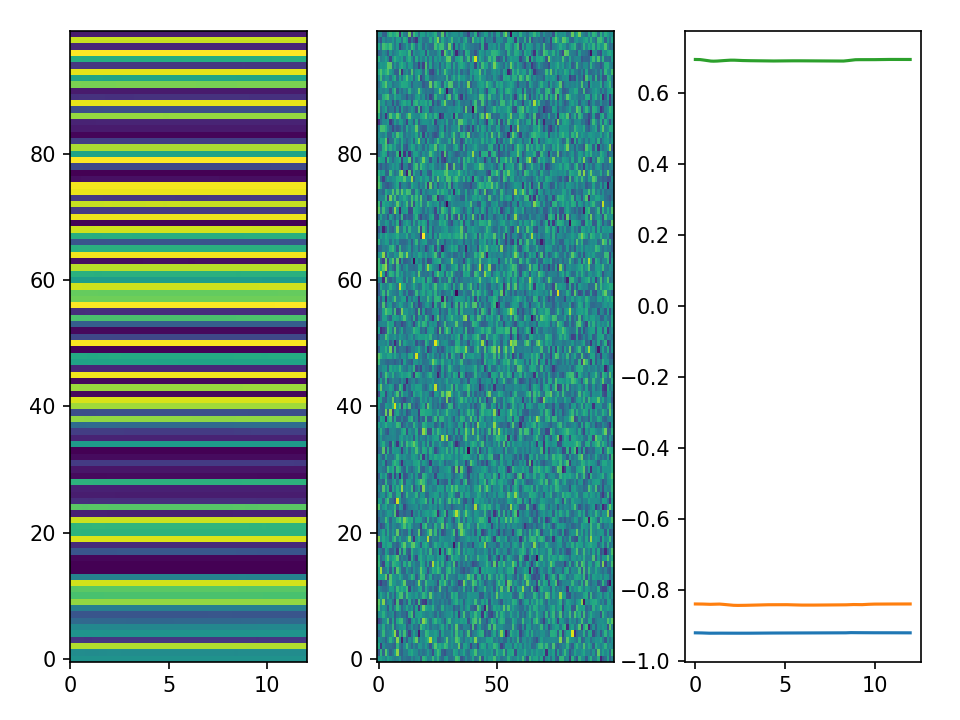

In [16]:
figure, subplots = plt.subplots(1, 3)
figure.tight_layout()
figure.subplots_adjust(hspace = 0.4, wspace = 0.3)
subplots[0].pcolormesh(
        np.arange(0, data_params['sim_time'], data_params['dt']),
        np.arange(0, data_params['n_neurons_A']),
        data['A']
        )

subplots[1].pcolormesh(
        np.arange(0, data_params['n_neurons_A']),
        np.arange(0, data_params['n_neurons_A']),
                  connections['A']['A']['J']
                  )

for _ in range(3):
    idx = npr.randint(0, data_params['n_neurons_A'] - 1)
    subplots[2].plot(
            np.arange(0, data_params['sim_time'], data_params['dt']),
            data['A'][idx, :],
            )

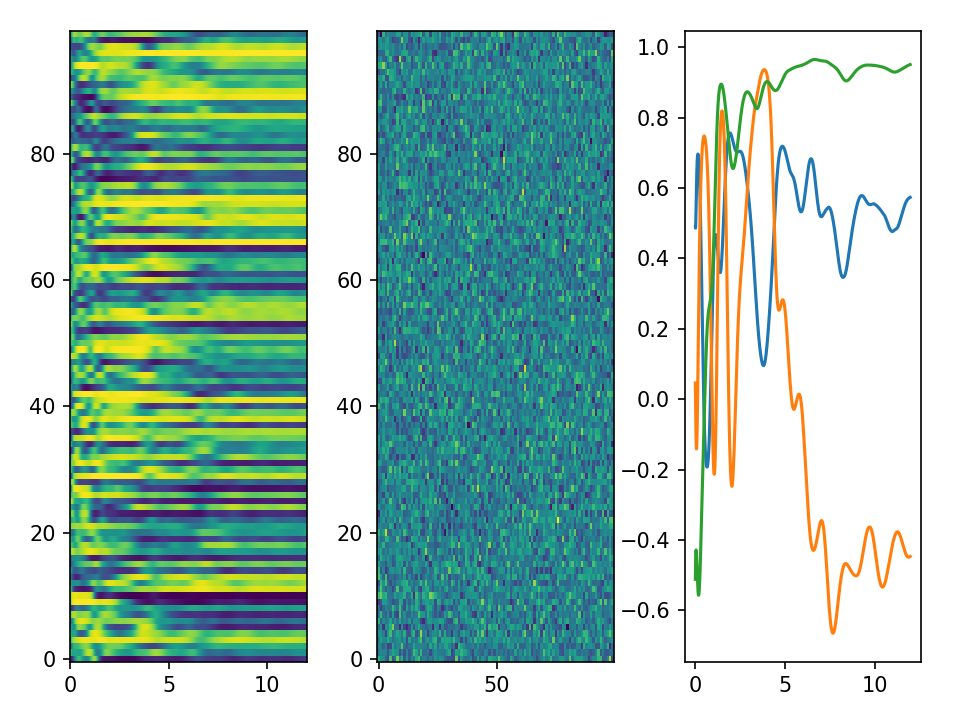

In [17]:
figure, subplots = plt.subplots(1, 3)
figure.tight_layout()
figure.subplots_adjust(hspace = 0.4, wspace = 0.3)
subplots[0].pcolormesh(
        np.arange(0, data_params['sim_time'], data_params['dt']),
        np.arange(0, data_params['n_neurons_B']),
        data['B']
        )

subplots[1].pcolormesh(
        np.arange(0, data_params['n_neurons_B']),
        np.arange(0, data_params['n_neurons_B']),
                  connections['B']['B']['J']
                  )

for _ in range(3):
    idx = npr.randint(0, data_params['n_neurons_B'] - 1)
    subplots[2].plot(
            np.arange(0, data_params['sim_time'], data_params['dt']),
            data['B'][idx, :],
            )

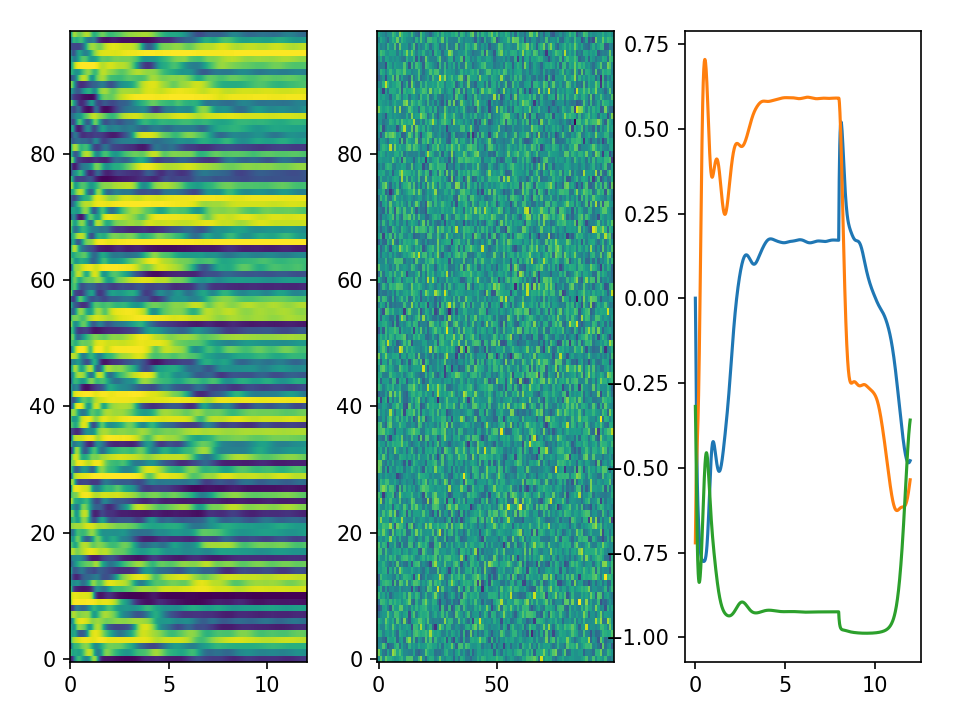

In [18]:
figure, subplots = plt.subplots(1, 3)
figure.tight_layout()
figure.subplots_adjust(hspace = 0.4, wspace = 0.3)
subplots[0].pcolormesh(
        np.arange(0, data_params['sim_time'], data_params['dt']),
        np.arange(0, data_params['n_neurons_c']),
        data['b']
        )

subplots[1].pcolormesh(
        np.arange(0, data_params['n_neurons_c']),
        np.arange(0, data_params['n_neurons_c']),
                  connections['c']['c']['j']
                  )

for _ in range(3):
    idx = npr.randint(0, data_params['n_neurons_c'] - 1)
    subplots[2].plot(
            np.arange(0, data_params['sim_time'], data_params['dt']),
            data['c'][idx, :],
            )

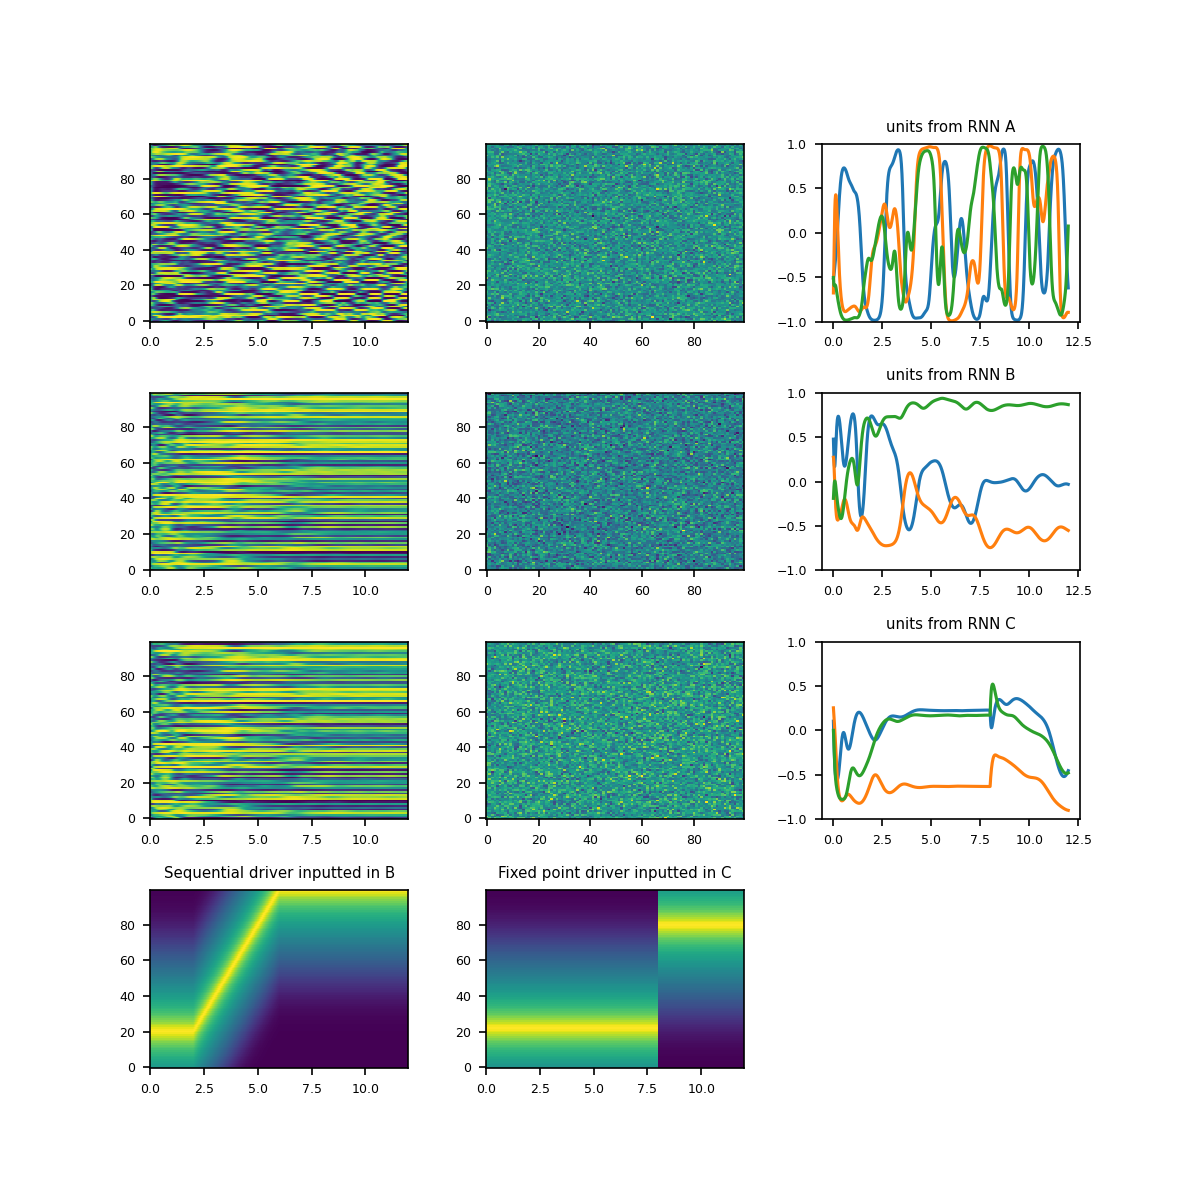

Text(0.5, 1.0, 'Fixed point driver inputted in C')

In [19]:
fig = plt.figure(figsize=[8, 8])
fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.3)
plt.rcParams.update({'font.size': 6})



ax = fig.add_subplot(4, 3, 1)
ax.pcolormesh(
        np.arange(0, data_params['sim_time'], data_params['dt']),
        np.arange(0, data_params['n_neurons_A']),
        data['A']
        )

ax = fig.add_subplot(4, 3, 2)
ax.pcolormesh(
        np.arange(0, data_params['n_neurons_A']),
        np.arange(0, data_params['n_neurons_A']),
                  connections['A']['A']['J']
                  )

ax = fig.add_subplot(4, 3, 3)
for _ in range(3):
    idx = npr.randint(0, data_params['n_neurons_A'] - 1)
    ax.plot(
            np.arange(0, data_params['sim_time'], data_params['dt']),
            data['A'][idx, :],
            )
ax.set_ylim(-1, 1)
ax.set_title('units from RNN A')

ax = fig.add_subplot(4, 3, 4)
ax.pcolormesh(
        np.arange(0, data_params['sim_time'], data_params['dt']),
        np.arange(0, data_params['n_neurons_B']),
        data['B']
        )

ax = fig.add_subplot(4, 3, 5)
ax.pcolormesh(
        np.arange(0, data_params['n_neurons_B']),
        np.arange(0, data_params['n_neurons_B']),
                  connections['B']['B']['J']
                  )

ax = fig.add_subplot(4, 3, 6)
for _ in range(3):
    idx = npr.randint(0, data_params['n_neurons_B'] - 1)
    ax.plot(
            np.arange(0, data_params['sim_time'], data_params['dt']),
            data['B'][idx, :],
            )
ax.set_ylim(-1, 1)
ax.set_title('units from RNN B')

ax = fig.add_subplot(4, 3, 7)
figure.subplots_adjust(hspace = 0.4, wspace = 0.3)
ax.pcolormesh(
        np.arange(0, data_params['sim_time'], data_params['dt']),
        np.arange(0, data_params['n_neurons_C']),
        data['B']
        )

ax = fig.add_subplot(4, 3, 8)
ax.pcolormesh(
        np.arange(0, data_params['n_neurons_C']),
        np.arange(0, data_params['n_neurons_C']),
                  connections['C']['C']['J']
                  )

ax = fig.add_subplot(4, 3, 9)
for _ in range(3):
    idx = npr.randint(0, data_params['n_neurons_C'] - 1)
    ax.plot(
            np.arange(0, data_params['sim_time'], data_params['dt']),
            data['C'][idx, :],
            )
ax.set_ylim(-1, 1)
ax.set_title('units from RNN C')








ax = fig.add_subplot(4, 3, 10)

ax.pcolormesh(
        np.arange(0, data_params['sim_time'], data_params['dt']),
        np.arange(0, data_params['n_neurons_B']),
        data['sequential']/np.max(data['sequential']))
ax.set_title("Sequential driver inputted in B")

ax = fig.add_subplot(4, 3, 11)
ax.pcolormesh(
        np.arange(0, data_params['sim_time'], data_params['dt']),
        np.arange(0, data_params['n_neurons_C']),
        data['fixed']/np.max(data['fixed']))
ax.set_title("Fixed point driver inputted in C")

# In silico experiment example

## Initialization

In [ ]:
n_target_neurons = 300
learnList = npr.permutation(n_target_neurons)
target_neurons = learnList[:n_target_neurons]

sim_param = {
        'n_neurons' : 300,
        'g' : 1.2,
        'tau_neuron' : 0.1,
        'tau_input' : 0.1,
        'scale_input' : 0.01,
        'dt' : 0.002,
        'data_dt' : data_params['dt'],
        'sim_time' : data_params['sim_time'], #in seconds
        'learning_rate' : 1.0,
        'activation_function' : np.tanh,
        'target_neurons' : target_neurons,
        }

neurons = init_neurons(sim_param['n_neurons'])
J = init_synapses(sim_param['n_neurons'])
P = init_P(sim_param['n_neurons'], sim_param['learning_rate'])
H = compute_input(
        sim_param['n_neurons'],
        sim_param['tau_input'],
        sim_param['scale_input'],
        sim_param['dt'],
        sim_param['sim_time'])
experimental_data = np.concatenate((data['A'], data['B'], data['C']), axis = 0)
t = 0

## Training

In [ ]:
def run(neurons, J, H, P, experimental_data, sim_param, training = True):
    timestep = 0
    chi2 = 0
    simulated_activity = np.zeros((sim_param['n_neurons'], int(sim_param['sim_time'] / sim_param['dt'])))
    neurons = experimental_data[:, 0, np.newaxis]
    n_timesteps = int(sim_param['sim_time'] / sim_param['dt'])
    while timestep < n_timesteps:
        activity = get_activity(neurons, sim_param['activation_function'])
        simulated_activity[:, timestep, np.newaxis] = activity
        neurons = update_voltage(neurons,
                                 sim_param['g'],
                                 J,
                                 H[:, timestep, np.newaxis],
                                 activity,
                                 sim_param['tau_neuron'],
                                 sim_param['dt'],
                                 )

        if training and timestep % int(sim_param['data_dt'] / sim_param['dt']) == 0:
            data_timestep = int(timestep / (sim_param['data_dt'] / sim_param['dt']))
            J, P, chi2_temp = train(
                    activity,
                    experimental_data[:, data_timestep, np.newaxis],
                    J,
                    P,
                    sim_param['target_neurons'],
                    )
            chi2 += chi2_temp
        timestep += 1
    return simulated_activity, J, P, chi2

In [20]:
test, J, P, chi2 = run(neurons, J, H, P, experimental_data, sim_param)
distance = np.linalg.norm(experimental_data - test[:, [i*5 for i in range(experimental_data.shape[1])]])
pvar = 1 - (distance / (math.sqrt(300 * 1200)) * np.std(experimental_data)) ** 2
print(chi2, pvar)

1.2736171478860436 0.9995399674676603


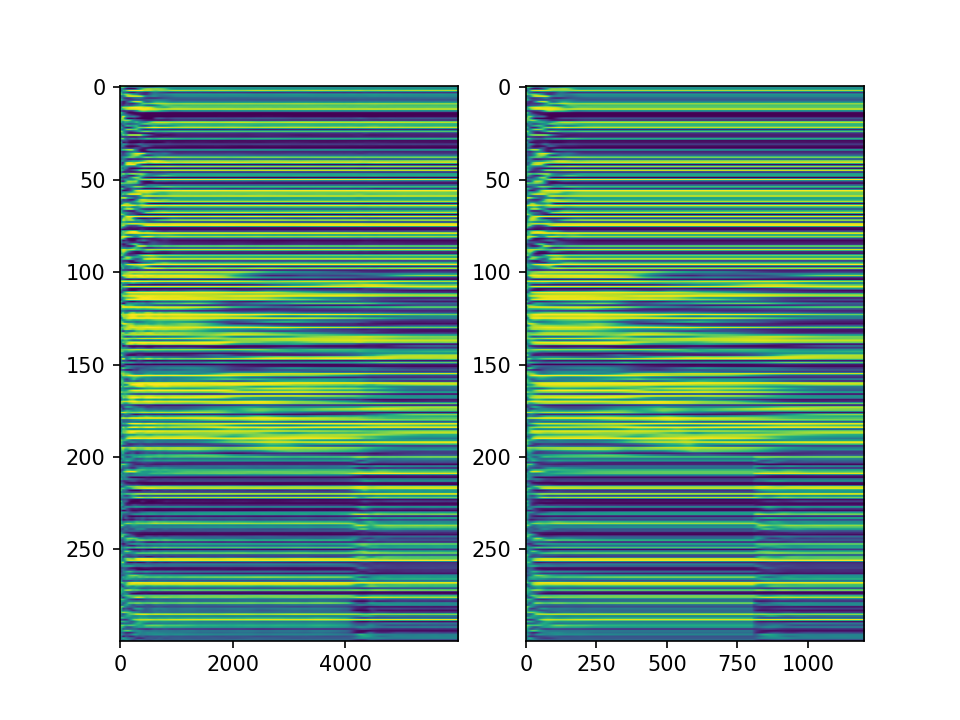

In [21]:
figure, subplots = plt.subplots(1, 2)
subplots[0].imshow(test, aspect = 'auto')
subplots[1].imshow(experimental_data, aspect = 'auto')

In [ ]:
def threeRegionSim(number_units=100,
                   ga=1.8,
                   gb=1.5,
                   gc=1.5,
                   tau=0.1,
                   fracInterReg=0.05,
                   ampInterReg=0.02,
                   fracExternal=0.5,
                   ampInB=1,
                   ampInC=-1,
                   dtData=0.01,
                   T=10,
                   leadTime=2,
                   bumpStd=0.2,
                   plotSim=True):
    """
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    %
    % out = threeRegionSim(params)
    %
    % Generates a simulated dataset with three interacting regions. Ref:
    %
    % Perich MG et al. Inferring brain-wide interactions using data-constrained
    % recurrent neural network models. bioRxiv. DOI:
    %
    % INPUTS:
    %   params : (optional) parameter struct. See code below for options.
    %
    % OUTPUTS:
    %   out : output struct with simulation results and parameters
    %
    % Written by Matthew G. Perich. Updated December 2020.
    %
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    Parameters
    ----------

    number_units: int
        number of units in each region
    ga: float
        chaos parameter for Region A
    gb: float
        chaos parameter for Region B
    gc: float
        chaos parameter for Region C
    tau: float
        decay time constant of RNNs
    fracInterReg: float
        fraction of inter-region connections
    ampInterReg: float
        amplitude of inter-region connections
    fracExternal: float
        fraction of external inputs to B/C
    ampInB: float
        amplitude of external inputs to Region B
    ampInC: float
        amplitude of external inputs to Region C
    dtData: float
        time step (s) of the simulation
    T: float
        total simulation time
    leadTime: float
        time before sequence starts and after FP moves
    bumpStd: float
        width (in frac of population) of sequence/FP
    plotSim: bool
        whether to plot the results
    """
    tData = np.arange(0, (T + dtData), dtData)

    # for now it only works if the networks are the same size
    Na = Nb = Nc = number_units

    # set up RNN A (chaotic responder)
    Ja = npr.randn(Na, Na)
    Ja = ga / math.sqrt(Na) * Ja
    hCa = 2 * npr.rand(Na, 1) - 1  # start from random state

    # set up RNN B (driven by sequence)
    Jb = npr.randn(Nb, Nb)
    Jb = gb / math.sqrt(Na) * Jb
    hCb = 2 * npr.rand(Nb, 1) - 1  # start from random state

    # set up RNN C (driven by fixed point)
    Jc = npr.randn(Nc, Nc)
    Jc = gb / math.sqrt(Na) * Jc
    hCc = 2 * npr.rand(Nc, 1) - 1  # start from random state

    # generate external inputs
    # set up sequence-driving network
    xBump = np.zeros((Nb, len(tData)))
    sig = bumpStd*Nb  # width of bump in N units

    norm_by = 2*sig ** 2
    cut_off = math.ceil(len(tData)/2) - 100
    for i in range(Nb):
        stuff = (i - sig - Nb * tData / (tData[-1] / 2)) ** 2 / norm_by
        xBump[i, :] = np.exp(-stuff)
        xBump[i, cut_off:] = xBump[i, cut_off]

    hBump = np.log((xBump+0.01)/(1-xBump+0.01))
    hBump = hBump-np.min(hBump)
    hBump = hBump/np.max(hBump)

    # set up fixed points driving network

    xFP = np.zeros((Nc, len(tData)))
    cut_off = math.ceil(len(tData)/2) + 100
    for i in range(Nc):
        front = xBump[i, 10] * np.ones((1, cut_off))
        back = xBump[i, 300] * np.ones((1, len(tData)-cut_off))
        xFP[i, :] = np.concatenate((front, back), axis=1)
    hFP = np.log((xFP+0.01)/(1-xFP+0.01))
    hFP = hFP - np.min(hFP)
    hFP = hFP/np.max(hFP)

    # add the lead time
    extratData = np.arange(tData[-1] + dtData, T + leadTime, dtData)
    tData = np.concatenate((tData, extratData))

    newmat = np.tile(hBump[:, 1, np.newaxis], (1, math.ceil(leadTime/dtData)))
    hBump = np.concatenate((newmat, hBump), axis=1)

    newmat = np.tile(hFP[:, 1, np.newaxis], (1, math.ceil(leadTime/dtData)))
    hFP = np.concatenate((newmat, hFP), axis=1)

    # build connectivity between RNNs
    Nfrac = int(fracInterReg*number_units)

    rand_idx = npr.permutation(number_units)
    w_A2B = np.zeros((number_units, 1))
    w_A2B[rand_idx[0:Nfrac]] = 1

    rand_idx = npr.permutation(number_units)
    w_A2C = np.zeros((number_units, 1))
    w_A2C[rand_idx[0:Nfrac]] = 1

    rand_idx = npr.permutation(number_units)
    w_B2A = np.zeros((number_units, 1))
    w_B2A[rand_idx[0:Nfrac]] = 1

    rand_idx = npr.permutation(number_units)
    w_B2C = np.zeros((number_units, 1))
    w_B2C[rand_idx[0:Nfrac]] = 1

    rand_idx = npr.permutation(number_units)
    w_C2A = np.zeros((number_units, 1))
    w_C2A[rand_idx[0:Nfrac]] = 1

    rand_idx = npr.permutation(number_units)
    w_C2B = np.zeros((number_units, 1))
    w_C2B[rand_idx[0:Nfrac]] = 1

    # Sequence only projects to B
    Nfrac = int(fracExternal * number_units)
    rand_idx = npr.permutation(number_units)
    w_Seq2B = np.zeros((number_units, 1))
    w_Seq2B[rand_idx[0:Nfrac]] = 1

    # Fixed point only projects to A
    Nfrac = int(fracExternal * number_units)
    rand_idx = npr.permutation(number_units)
    w_Fix2C = np.zeros((number_units, 1))
    w_Fix2C[rand_idx[0:Nfrac]] = 1

    # generate time series simulated data
    Ra = np.empty((Na, len(tData) - 1))
    Ra[:] = np.NaN

    Rb = np.empty((Nb, len(tData) - 1))
    Rb[:] = np.NaN

    Rc = np.empty((Nc, len(tData) - 1))
    Rc[:] = np.NaN

    for tt in range(len(tData) - 1):
        Ra[:, tt, np.newaxis] = np.tanh(hCa)
        Rb[:, tt, np.newaxis] = np.tanh(hCb)
        Rc[:, tt, np.newaxis] = np.tanh(hCc)
        # chaotic responder
        JRa = Ja.dot(Ra[:, tt, np.newaxis])
        JRa += ampInterReg * w_B2A * Rb[:, tt, np.newaxis]
        JRa += ampInterReg * w_C2A * Rc[:, tt, np.newaxis]
        hCa = hCa + dtData * (-hCa + JRa) / tau

        # sequence driven
        JRb = Jb.dot(Rb[:, tt, np.newaxis])
        JRb += ampInterReg * w_A2B * Ra[:, tt, np.newaxis]
        JRb += ampInterReg * w_C2B * Rc[:, tt, np.newaxis]
        JRb += ampInB * w_Seq2B * hBump[:, tt, np.newaxis]
        hCb = hCb + dtData * (-hCb + JRb) / tau

        # fixed point driven
        JRc = Jc.dot(Rc[:, tt, np.newaxis])
        JRc += ampInterReg * w_B2C * Rb[:, tt, np.newaxis]
        JRc += ampInterReg * w_A2C * Ra[:, tt, np.newaxis]
        JRc += ampInC * w_Fix2C * hFP[:, tt, np.newaxis]
        hCc = hCc + dtData * (-hCc + JRc) / tau

    # package up outputs
    Rseq = hBump.copy()
    Rfp = hFP.copy()
    # normalize
    Ra = Ra/np.max(Ra)
    Rb = Rb/np.max(Rb)
    Rc = Rc/np.max(Rc)
    Rseq = Rseq/np.max(Rseq)
    Rfp = Rfp/np.max(Rfp)

    out_params = {}
    out_params['Na'] = Na
    out_params['Nb'] = Nb
    out_params['Nc'] = Nc
    out_params['ga'] = ga
    out_params['gb'] = gb
    out_params['gc'] = gc
    out_params['tau'] = tau
    out_params['fracInterReg'] = fracInterReg
    out_params['ampInterReg'] = ampInterReg
    out_params['fracExternal'] = fracExternal
    out_params['ampInB'] = ampInB
    out_params['ampInC'] = ampInC
    out_params['dtData'] = dtData
    out_params['T'] = T
    out_params['leadTime'] = leadTime
    out_params['bumpStd'] = bumpStd

    out = {}
    out['Ra'] = Ra
    out['Rb'] = Rb
    out['Rc'] = Rc
    out['Rseq'] = Rseq
    out['Rfp'] = Rfp
    out['tData'] = tData
    out['Ja'] = Ja
    out['Jb'] = Jb
    out['Jc'] = Jc
    out['w_A2B'] = w_A2B
    out['w_A2C'] = w_A2C
    out['w_B2A'] = w_B2A
    out['w_B2C'] = w_B2C
    out['w_C2A'] = w_C2A
    out['w_C2B'] = w_C2B
    out['w_Fix2C'] = w_Fix2C
    out['w_Seq2B'] = w_Seq2B
    out['params'] = out_params


    if plotSim is True:
        fig = plt.figure(figsize=[8, 8])
        fig.tight_layout()
        fig.subplots_adjust(hspace=0.4, wspace=0.3)
        plt.rcParams.update({'font.size': 6})

        ax = fig.add_subplot(4, 3, 1)
        ax.pcolormesh(tData, range(Na), Ra)
        ax.set_title('RNN A - g={}'.format(ga))

        ax = fig.add_subplot(4, 3, 2)
        ax.pcolormesh(range(Na), range(Na), Ja)
        ax.set_title('DI matrix A')

        ax = fig.add_subplot(4, 3, 3)
        for _ in range(3):
            idx = random.randint(0, Na-1)
            ax.plot(tData, Ra[idx, :])
        ax.set_ylim(-1, 1)
        ax.set_title('units from RNN A')

        ax = fig.add_subplot(4, 3, 4)
        ax.pcolormesh(tData, range(Nb), Rb)
        ax.set_title('RNN B - g={}'.format(gb))

        ax = fig.add_subplot(4, 3, 5)
        ax.pcolormesh(range(Nb), range(Nb), Jb)
        ax.set_title('DI matrix B')

        ax = fig.add_subplot(4, 3, 6)
        for _ in range(3):
            idx = random.randint(0, Nb-1)
            ax.plot(tData, Rb[idx, :])
        ax.set_ylim(-1, 1)
        ax.set_title('units from RNN B')

        ax = fig.add_subplot(4, 3, 7)
        ax.pcolormesh(tData, range(Nc), Rc)
        ax.set_title('RNN C - g={}'.format(gc))

        ax = fig.add_subplot(4, 3, 8)
        ax.pcolormesh(range(Nc), range(Nc), Jc)
        ax.set_title('DI matrix C')

        ax = fig.add_subplot(4, 3, 9)
        for _ in range(3):
            idx = random.randint(0, Nc-1)
            ax.plot(tData, Rc[idx, :])
        ax.set_ylim(-1, 1)
        ax.set_title('units from RNN C')

        ax = fig.add_subplot(4, 3, 10)
        ax.pcolormesh(tData, range(Nc), Rfp)
        ax.set_title('Fixed Point Driver')

        ax = fig.add_subplot(4, 3, 11)
        ax.pcolormesh(tData, range(Nc), Rseq)
        ax.set_title('Sequence Driver')
    return out

sim = threeRegionSim(
        number_units = 100,
        plotSim = False
        )

In [ ]:
activity = np.concatenate((sim['Ra'], sim['Rb'], sim['Rc']), axis=0)
activity = activity / activity.max()
activity = np.minimum(activity, 0.999)
activity = np.maximum(activity, -0.999)

0 20.742324572388007 0.9933489579071237


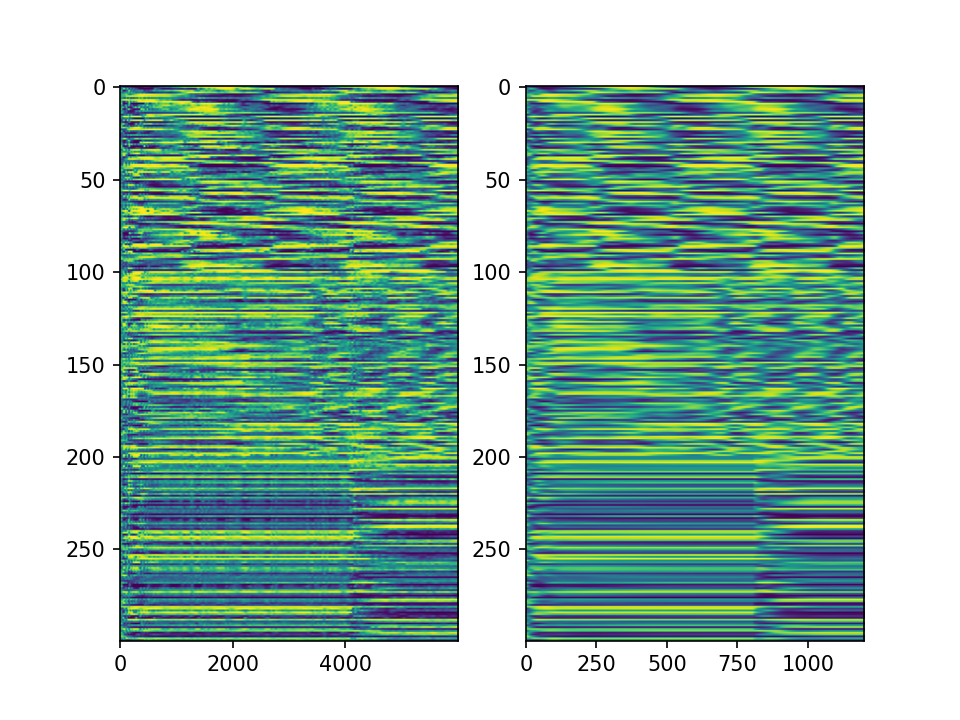


1 5.7348968807736584 0.9981611009692181
2 4.4122423922283405 0.9985852111332908
---------------------------------------------------------------------------
KeyboardInterrupt                         Traceback (most recent call last)
Cell In[100], line 5
      3 prev_test = None
      4 while i < 600:
----> 5     test, J, P, chi2 = run(neurons, J, H, P, activity, sim_param)
      6     distance = np.linalg.norm(activity - test[:, [i*5 for i in range(activity.shape[1])]])
      7     pvar = 1 - (distance / (math.sqrt(300 * 1200)) * np.std(activity)) ** 2

Cell In[87], line 21, in run(neurons, J, H, P, experimental_data, sim_param, training)
     19 if training and timestep % int(sim_param['data_dt'] / sim_param['dt']) == 0:
     20     data_timestep = int(timestep / (sim_param['data_dt'] / sim_param['dt']))
---> 21     J, P, chi2_temp = train(
     22             activity,
     23             experimental_data[:, data_timestep, np.newaxis],
     24             J,
     25             P,
 

In [22]:
i = 0
test = None
prev_test = None
while i < 600:
    test, J, P, chi2 = run(neurons, J, H, P, activity, sim_param)
    distance = np.linalg.norm(activity - test[:, [i*5 for i in range(activity.shape[1])]])
    pvar = 1 - (distance / (math.sqrt(300 * 1200)) * np.std(activity)) ** 2
    print(i, chi2, pvar)

    if i > 500 or i % 100 == 0:
        figure, subplots = plt.subplots(1, 2)
        subplots[0].imshow(test, aspect = 'auto')
        subplots[1].imshow(activity, aspect = 'auto')
        plt.show()
    i += 1